In [4]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy, argparse
import multiprocessing
from matplotlib import pyplot as plt
from torchvision import transforms
print(os.getcwd())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

torch.manual_seed(1)

/home/mtweed/Documents/New_College/S_2/Machine_Learning/Problem_Sets/GP4


# Introduction

The task for this assignment was to construct a convolutional neural network that could classify impressionist paintings with respect to their artists. The goal was to train a model that acquire roughly ~50% accuracy. 

As an initial frame for this assignment, we chose to apply transfer learning procedures so as to familiarize ourselves with the method and the power that comes with using a "headless" pre-trained network. In this we tested the efficacy of the `resnet18` and `inception` models.

For our custom models, we chose to evaluate different model architectures and variations on the structures such as dropout and batch-normalization. The models and their corresponding architectures are outlined below

- Initial Model
    - 2 Convolutional Layers
        - 16 channels, 3x3 kernel, 1 stride, 1 padding
        - 32 channels, 3x3 kernel, 1 stride, 1 padding
    - 2 Max-pooling layers
        - 2x2
    - 2 Fully Connected Layers
- Overfit Model
    - 1 Convolutional Layer 
        - 16 channels, 3x3 kernel, 1 stride, 1 padding
    - 1 Max pooling layer 
        - 2x2
    - 2 Fully Connected Layers
- Dropout Model
    - 1 Convolutional Layer 
        - 16 channels, 3x3 kernel, 1 stride, 1 padding
    - 1 Max pooling layer 
        - 2x2
    - 1 Dropout layer
    - 2 Fully Connected Layers

For all these models we chose to use the `Adam` optimizer with a learning rate of 0.001

# Transfer Learning



## Res-Net 18

In [5]:
train_dir = "data/training/"
val_dir = "data/validation/"

In [10]:
data_transforms = {
    'training':transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation':transforms.Compose([
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ]),
}
train_data = datasets.ImageFolder(root=train_dir, transform = data_transforms['training'])
val_data = datasets.ImageFolder(root=val_dir, transform = data_transforms['validation'])

train_loader = data.DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=True, drop_last=True)
val_loader = data.DataLoader(val_data, batch_size=4, shuffle=True, pin_memory=True, drop_last=True)

class_names = train_data.classes
print(class_names)

['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']


In [11]:
# Get pre-trained model
model_rn18 = models.resnet18(pretrained=True)

#Get input for new fully connected layer
n_ftrs = model_rn18.fc.in_features
# set fully connected layers to 
model_rn18.fc = nn.Linear(n_ftrs,len(class_names))
print(n_ftrs)

model_rn18 = model_rn18.to(device)

512


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_rn18.parameters(), lr=0.001, momentum=0.95)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set number of Epochs
n_epochs = 10

In [13]:
phase = 'training'

best_model_wts = copy.deepcopy(model_rn18.state_dict())
best_acc = 0

for epoch in range(n_epochs):
  phase = 'training'
  print(epoch)
  run_loss = 0
  run_corr = 0
  model_rn18.train()
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      outputs = model_rn18(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
        
      loss.backward()
      optimizer.step()
        
    run_loss += loss.item() + inputs.size(0)
    run_corr += torch.sum(preds == labels.data)

  scheduler.step()
  
  epoch_loss = run_loss / len(train_data)
  epoch_acc = run_corr.double() / len(train_data)
  print('Training: \n {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

  phase = 'validation'
  run_loss = 0
  run_corr = 0
  model_rn18.eval()
  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
      outputs = model_rn18(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
              
    run_loss += loss.item() + inputs.size(0)
    run_corr += torch.sum(preds == labels.data)

  epoch_loss = run_loss / len(val_data)
  epoch_acc = run_corr.double() / len(val_data)

  if epoch_acc > best_acc:
    best_acc = epoch_acc
    best_model_wts = copy.deepcopy(model_rn18.state_dict())
  
  print('Validation: \n {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

torch.save(model_rn18, 'rn18_nonnormalized.pt')

0
Training: 
 0 Loss: 1.5822 Acc: 0.2989
Validation: 
 0 Loss: 1.6152 Acc: 0.3010
1
Training: 
 1 Loss: 1.4514 Acc: 0.4200
Validation: 
 1 Loss: 1.5247 Acc: 0.3515
2
Training: 
 2 Loss: 1.3877 Acc: 0.4900
Validation: 
 2 Loss: 1.4282 Acc: 0.4485
3
Training: 
 3 Loss: 1.3552 Acc: 0.5281
Validation: 
 3 Loss: 1.4650 Acc: 0.4303
4
Training: 
 4 Loss: 1.3386 Acc: 0.5604
Validation: 
 4 Loss: 1.4382 Acc: 0.4576
5
Training: 
 5 Loss: 1.3266 Acc: 0.5730
Validation: 
 5 Loss: 1.4001 Acc: 0.4758
6
Training: 
 6 Loss: 1.3007 Acc: 0.5995
Validation: 
 6 Loss: 1.4409 Acc: 0.4889
7
Training: 
 7 Loss: 1.2435 Acc: 0.6803
Validation: 
 7 Loss: 1.3483 Acc: 0.5424
8
Training: 
 8 Loss: 1.2198 Acc: 0.7154
Validation: 
 8 Loss: 1.3422 Acc: 0.5596
9
Training: 
 9 Loss: 1.2083 Acc: 0.7324
Validation: 
 9 Loss: 1.3294 Acc: 0.5768


## Inception Net

# CODE I STOLE

In [21]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
        #                     [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
        #                     [0.229, 0.224, 0.225])
    ])
}

In [22]:
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=val_dir, transform=image_transforms['valid'])
}
  
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

In [23]:
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=10, shuffle=True, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=10, shuffle=True, pin_memory=True, drop_last=True)
}
 
# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)
  
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])
 
# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Classes: ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
Training-set size: 3988 
Validation-set size: 990


In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #Epoch Results
    results = {"train": {"loss" : [], "acc": []},\
               "valid": {"loss" : [], "acc": []}}
     
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch + 1}/{n_epochs}')
        print('**' * 8, '\n')

        #iterate through phases during each epoch
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  
            running_loss = 0.0
            running_corrects = 0
 
            #iterate through images in phase
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
 
                #zero parameter gradients
                optimizer.zero_grad()
 
                with torch.set_grad_enabled(phase == 'train'): #enable auto_grad if training, disable if validating
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
 
                    if phase == 'train': #Back-propogate and modify if training
                        loss.backward()
                        optimizer.step()

                #track loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train': # Adjust learning rate if training
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
 
# Record training loss and accuracy for each phase
            results[phase]["loss"].append(epoch_loss)
            results[phase]["acc"].append(epoch_acc)
 
# deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
    time_elapsed = time.time() - since
    print(f'Training complete in {round(time_elapsed // 60)}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')
 
# load best model weights
    model.load_state_dict(best_model_wts)
    return model, results


# Custom Models
https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch

## 2 Conv w/ 2 Linear FC Layers

### Overfit

In [25]:
from torch.autograd import Variable
import torch.nn.functional as F

class overfit2_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(overfit2_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
        self.fc1 = torch.nn.Linear(32 * 64 * 64, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        # 3 -> 16 Channels
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)


        # 16 -> 32 Channels
        x = F.relu(self.conv2(x))
        #Size changes from (32, 128, 128) to (32, 64, 64)
        x = self.pool2(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (32, 64, 64) to (1, 131072)
        x = x.view(-1, 32 * 64 * 64)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 131072) to (1, 64)
        x = F.relu(self.fc1(x))
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [26]:
myCNN = overfit2_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
exp_lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [27]:
overfit2_model, overfit2_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.1697 Acc: 0.2029
valid Loss: 2.0595 Acc: 0.2869
Epoch: 2/10
**************** 

train Loss: 1.9930 Acc: 0.2889
valid Loss: 2.0175 Acc: 0.3030
Epoch: 3/10
**************** 

train Loss: 1.9289 Acc: 0.3302
valid Loss: 1.9424 Acc: 0.3323
Epoch: 4/10
**************** 

train Loss: 1.7998 Acc: 0.3754
valid Loss: 1.8566 Acc: 0.3747
Epoch: 5/10
**************** 

train Loss: 1.7744 Acc: 0.3974
valid Loss: 1.8538 Acc: 0.3727
Epoch: 6/10
**************** 

train Loss: 1.7644 Acc: 0.3994
valid Loss: 1.8301 Acc: 0.3879
Epoch: 7/10
**************** 

train Loss: 1.7487 Acc: 0.3967
valid Loss: 1.8318 Acc: 0.3768
Epoch: 8/10
**************** 

train Loss: 1.7563 Acc: 0.3884
valid Loss: 1.8072 Acc: 0.3949
Epoch: 9/10
**************** 

train Loss: 1.7508 Acc: 0.4030
valid Loss: 1.8254 Acc: 0.3586
Epoch: 10/10
**************** 

train Loss: 1.7335 Acc: 0.3992
valid Loss: 1.8268 Acc: 0.3848
Training complete in 19m 12.536524534225464s
Best val Acc: 0.39494949

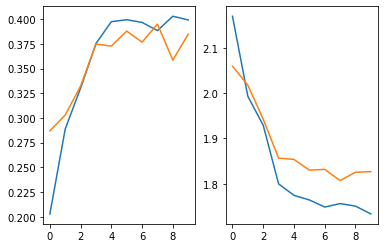

In [28]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(overfit2_results["train"][val])
    axs[i].plot(overfit2_results["valid"][val])

### w/ Dropout

In [29]:
from torch.autograd import Variable
import torch.nn.functional as F

class dropout2_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(dropout2_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
        self.drop = nn.Dropout2d(p = 0.5)

        self.fc1 = torch.nn.Linear(32 * 64 * 64, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        # 3 -> 16 Channels
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)


        # 16 -> 32 Channels
        x = F.relu(self.conv2(x))
        #Size changes from (32, 128, 128) to (32, 64, 64)
        x = self.pool2(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (32, 64, 64) to (1, 131072)
        x = x.view(-1, 32 * 64 * 64)

        #Dropout
        x = self.drop(x)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 131072) to (1, 64)
        x = F.relu(self.fc1(x))
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [30]:
myCNN = dropout2_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
exp_lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [31]:
dropout2_model, dropout2_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.1657 Acc: 0.2239
valid Loss: 2.0683 Acc: 0.2869
Epoch: 2/10
**************** 

train Loss: 2.0228 Acc: 0.2876
valid Loss: 2.0491 Acc: 0.2747
Epoch: 3/10
**************** 

train Loss: 1.9405 Acc: 0.3227
valid Loss: 2.0181 Acc: 0.3152
Epoch: 4/10
**************** 

train Loss: 1.8101 Acc: 0.3701
valid Loss: 1.8659 Acc: 0.3535
Epoch: 5/10
**************** 

train Loss: 1.7896 Acc: 0.3764
valid Loss: 1.8634 Acc: 0.3616
Epoch: 6/10
**************** 

train Loss: 1.7693 Acc: 0.3947
valid Loss: 1.8429 Acc: 0.3778
Epoch: 7/10
**************** 

train Loss: 1.7435 Acc: 0.3969
valid Loss: 1.8455 Acc: 0.3667
Epoch: 8/10
**************** 

train Loss: 1.7457 Acc: 0.3962
valid Loss: 1.8585 Acc: 0.3667
Epoch: 9/10
**************** 

train Loss: 1.7395 Acc: 0.3952
valid Loss: 1.8431 Acc: 0.3636
Epoch: 10/10
**************** 

train Loss: 1.7486 Acc: 0.3887
valid Loss: 1.8397 Acc: 0.3606
Training complete in 19m 7.134598016738892s
Best val Acc: 0.377777777

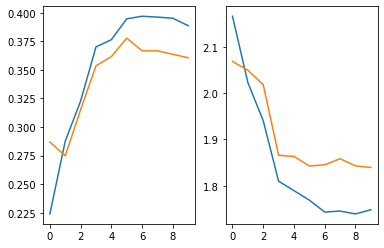

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(dropout2_results["train"][val])
    axs[i].plot(dropout2_results["valid"][val])

### w/ Batch-Norm

In [33]:
from torch.autograd import Variable
import torch.nn.functional as F

class batchnorm2_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    def __init__(self):
        super(batchnorm2_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2d = nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    

        self.fc1 = torch.nn.Linear(32 * 64 * 64, 64)
        self.bn1d = nn.BatchNorm1d(64)
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        # 3 -> 16 Channels
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)


        # 16 -> 32 Channels
        x = F.relu(self.bn2d(self.conv2(x)))
        #Size changes from (16, 128, 128) to (32, 64, 64)
        x = self.pool2(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (32, 64, 64) to (1, 131072)
        x = x.view(-1, 32 * 64 * 64)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 131072) to (1, 64)
        x = F.relu(self.bn1d(self.fc1(x)))
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [34]:
myCNN = batchnorm2_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
exp_lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [35]:
batchnorm2_model, batchnorm2_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.0340 Acc: 0.2738
valid Loss: 2.1526 Acc: 0.2545
Epoch: 2/10
**************** 

train Loss: 1.9118 Acc: 0.3310
valid Loss: 1.9510 Acc: 0.3283
Epoch: 3/10
**************** 

train Loss: 1.8503 Acc: 0.3448
valid Loss: 1.8560 Acc: 0.3566
Epoch: 4/10
**************** 

train Loss: 1.7994 Acc: 0.3679
valid Loss: 1.8303 Acc: 0.3586
Epoch: 5/10
**************** 

train Loss: 1.7765 Acc: 0.3809
valid Loss: 2.0584 Acc: 0.3101
Epoch: 6/10
**************** 

train Loss: 1.7592 Acc: 0.3829
valid Loss: 2.0557 Acc: 0.2939
Epoch: 7/10
**************** 

train Loss: 1.7233 Acc: 0.3929
valid Loss: 1.7898 Acc: 0.3859
Epoch: 8/10
**************** 

train Loss: 1.6374 Acc: 0.4250
valid Loss: 1.6735 Acc: 0.4051
Epoch: 9/10
**************** 

train Loss: 1.6303 Acc: 0.4366
valid Loss: 1.6337 Acc: 0.4475
Epoch: 10/10
**************** 

train Loss: 1.6120 Acc: 0.4391
valid Loss: 1.6565 Acc: 0.4303
Training complete in 19m 31.845080852508545s
Best val Acc: 0.44747474

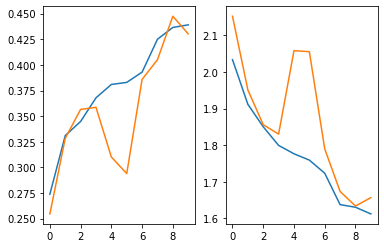

In [36]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(batchnorm2_results["train"][val])
    axs[i].plot(batchnorm2_results["valid"][val])

## 2 Conv w/ 1 Linear FC Layer & Crop (256)

In [43]:
data_transforms = {
    'training':transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation':transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [44]:
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=val_dir, transform=image_transforms['valid'])
}
  
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

In [45]:
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=10, shuffle=True, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=10, shuffle=True, pin_memory=True, drop_last=True)
}
 
# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)
  
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])
 
# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Classes: ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
Training-set size: 3988 
Validation-set size: 990


In [46]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1 - In: [3, 256, 256], Out:[16, 254, 254]
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1 - In: [16, 254, 254], Out:[16, 127, 127]
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2 - In: [16, 127, 127], Out:[32, 125, 125]
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2 - In: [32, 125, 125], Out:[32, 62, 62]
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 62 * 62, 10) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        #Flatten
        out = out.view(out.size(0), -1)

        #Dense
        out = self.fc1(out)
        
        return out

In [47]:
myCNN = CNNModel()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
exp_lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [48]:
Conv2_model, Conv2_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.3955 Acc: 0.0978
valid Loss: 2.3026 Acc: 0.1000
Epoch: 2/10
**************** 

train Loss: 2.2995 Acc: 0.0940
valid Loss: 2.3026 Acc: 0.1000
Epoch: 3/10
**************** 

train Loss: 2.2983 Acc: 0.0973
valid Loss: 2.3026 Acc: 0.1000
Epoch: 4/10
**************** 

train Loss: 2.2980 Acc: 0.0940
valid Loss: 2.3026 Acc: 0.1000
Epoch: 5/10
**************** 

train Loss: 2.2979 Acc: 0.0860
valid Loss: 2.3026 Acc: 0.1000
Epoch: 6/10
**************** 

train Loss: 2.2984 Acc: 0.0888
valid Loss: 2.3026 Acc: 0.1000
Epoch: 7/10
**************** 

train Loss: 2.2984 Acc: 0.0938
valid Loss: 2.3026 Acc: 0.1000
Epoch: 8/10
**************** 

train Loss: 2.2980 Acc: 0.0973
valid Loss: 2.3026 Acc: 0.1000
Epoch: 9/10
**************** 

train Loss: 2.2980 Acc: 0.0968
valid Loss: 2.3026 Acc: 0.1000
Epoch: 10/10
**************** 

train Loss: 2.2980 Acc: 0.0953
valid Loss: 2.3026 Acc: 0.1000
Training complete in 19m 14.09978437423706s
Best val Acc: 0.1


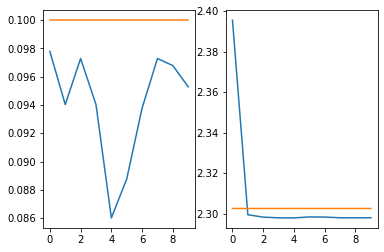

In [49]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(Conv2_results["train"][val])
    axs[i].plot(Conv2_results["valid"][val])

## 1 Conv

### Overfit

In [50]:
from torch.autograd import Variable
import torch.nn.functional as F

class overfit1_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(overfit1_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #262144 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(16 * 128 * 128, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 256, 256) to (16, 256, 256)
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (16, 128, 128) to (1, 262144)
        x = x.view(-1, 16 * 128 * 128)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 262144) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        #x = self.norm2(x)
        x = self.fc2(x)
        return(x)

In [51]:
train_data = datasets.ImageFolder(root=train_dir, transform = transforms.ToTensor())
val_data = datasets.ImageFolder(root=val_dir, transform = transforms.ToTensor())

train_loader = data.DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=True, drop_last=True)
val_loader = data.DataLoader(val_data, batch_size=4, shuffle=True, pin_memory=True, drop_last=True)

class_names = train_data.classes
print(class_names)

['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']


In [52]:
myCNN = overfit1_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [53]:
overfit1_model, overfit1_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.3784 Acc: 0.1788
valid Loss: 2.1825 Acc: 0.2212
Epoch: 2/10
**************** 

train Loss: 2.1111 Acc: 0.2427
valid Loss: 2.0951 Acc: 0.2606
Epoch: 3/10
**************** 

train Loss: 2.0314 Acc: 0.2721
valid Loss: 2.0935 Acc: 0.2444
Epoch: 4/10
**************** 

train Loss: 1.9877 Acc: 0.2909
valid Loss: 2.0014 Acc: 0.3030
Epoch: 5/10
**************** 

train Loss: 1.9296 Acc: 0.3144
valid Loss: 1.9921 Acc: 0.3172
Epoch: 6/10
**************** 

train Loss: 1.9263 Acc: 0.3122
valid Loss: 1.9378 Acc: 0.3212
Epoch: 7/10
**************** 

train Loss: 1.9044 Acc: 0.3260
valid Loss: 1.9530 Acc: 0.3313
Epoch: 8/10
**************** 

train Loss: 1.8991 Acc: 0.3285
valid Loss: 1.9690 Acc: 0.3081
Epoch: 9/10
**************** 

train Loss: 1.8823 Acc: 0.3327
valid Loss: 1.9057 Acc: 0.3444
Epoch: 10/10
**************** 

train Loss: 1.8602 Acc: 0.3490
valid Loss: 1.9172 Acc: 0.3242
Training complete in 18m 55.9312961101532s
Best val Acc: 0.3444444444

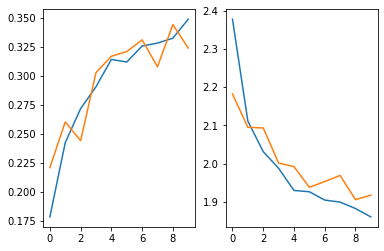

In [54]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(overfit1_results["train"][val])
    axs[i].plot(overfit1_results["valid"][val])

### w/ Dropout

In [57]:
from torch.autograd import Variable
import torch.nn.functional as F

class dropout1_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(dropout1_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.drop = nn.Dropout2d(p = 0.5)

        #262144 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(16 * 128 * 128, 64)
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 256, 256) to (16, 256, 256)
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (16, 128, 128) to (1, 262144)
        x = x.view(-1, 16 * 128 * 128)
        
        #Dropout
        x = self.drop(x)

        #Computes the activation of the first fully connected layer
        #Size changes from (1, 262144) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        #x = self.norm2(x)
        x = self.fc2(x)
        return(x)

In [58]:
myCNN = dropout1_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [59]:
dropout1_model, dropout1_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.8499 Acc: 0.1299
valid Loss: 2.3019 Acc: 0.1141
Epoch: 2/10
**************** 

train Loss: 2.2527 Acc: 0.1464
valid Loss: 2.2628 Acc: 0.1455
Epoch: 3/10
**************** 

train Loss: 2.2259 Acc: 0.1705
valid Loss: 2.2192 Acc: 0.1758
Epoch: 4/10
**************** 

train Loss: 2.1822 Acc: 0.1898
valid Loss: 2.2109 Acc: 0.1758
Epoch: 5/10
**************** 

train Loss: 2.1618 Acc: 0.2189
valid Loss: 2.1628 Acc: 0.2333
Epoch: 6/10
**************** 

train Loss: 2.1131 Acc: 0.2289
valid Loss: 2.1580 Acc: 0.2141
Epoch: 7/10
**************** 

train Loss: 2.0861 Acc: 0.2237
valid Loss: 2.1023 Acc: 0.2232
Epoch: 8/10
**************** 

train Loss: 2.0811 Acc: 0.2372
valid Loss: 2.0927 Acc: 0.2374
Epoch: 9/10
**************** 

train Loss: 2.0432 Acc: 0.2635
valid Loss: 2.0683 Acc: 0.2232
Epoch: 10/10
**************** 

train Loss: 2.0086 Acc: 0.2733
valid Loss: 2.0670 Acc: 0.2717
Training complete in 19m 0.8566892147064209s
Best val Acc: 0.27171717

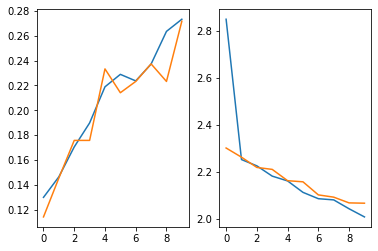

In [60]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(dropout1_results["train"][val])
    axs[i].plot(dropout1_results["valid"][val])

#### More Dropouts


Checking to see if more dropouts improve the model.

In [61]:
from torch.autograd import Variable
import torch.nn.functional as F

class dropout1_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(dropout1_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.drop = nn.Dropout2d(p = 0.5)

        #262144 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(16 * 128 * 128, 64)
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 256, 256) to (16, 256, 256)
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (16, 128, 128) to (1, 262144)
        x = x.view(-1, 16 * 128 * 128)
        


        #Computes the activation of the first fully connected layer
        #Size changes from (1, 262144) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Dropout
        x = self.drop(x)
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        #x = self.norm2(x)
        x = self.fc2(x)
        return(x)

In [62]:
myCNN = dropout1_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [ ]:
dropout1_model, dropout1_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Epoch: 1/10
**************** 

train Loss: 2.6403 Acc: 0.0995
valid Loss: 2.3031 Acc: 0.1010
Epoch: 2/10
**************** 

train Loss: 2.2990 Acc: 0.0995
valid Loss: 2.3028 Acc: 0.1010
Epoch: 3/10
**************** 

train Loss: 2.2986 Acc: 0.1001
valid Loss: 2.3027 Acc: 0.1000
Epoch: 4/10
**************** 

train Loss: 2.2984 Acc: 0.0998
valid Loss: 2.3026 Acc: 0.1000
Epoch: 5/10
**************** 

train Loss: 2.2984 Acc: 0.0918
valid Loss: 2.3026 Acc: 0.1000
Epoch: 6/10
**************** 

train Loss: 2.2984 Acc: 0.0883
valid Loss: 2.3026 Acc: 0.1000
Epoch: 7/10
**************** 



### w/ Batch Norm

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F

class batchnorm1_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(batchnorm1_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn2d = nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #262144 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(16 * 128 * 128, 64)

        self.bn1d = nn.BatchNorm1d(64)
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 256, 256) to (16, 256, 256)
        x = F.relu(self.bn2d(self.conv1(x)))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (16, 128, 128) to (1, 262144)
        x = x.view(-1, 16 * 128 * 128)

        #Computes the activation of the first fully connected layer
        #Size changes from (1, 262144) to (1, 64)
        x = F.relu(self.bn1d(self.fc1(x)))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        #x = self.norm2(x)
        x = self.fc2(x)
        return(x)

In [ ]:
myCNN = batchnorm1_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [ ]:
batchnorm1_model, batchnorm1_results= train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

Even with batch normalization, it appears that the model is over-fitting worse than it did in the dropout model.

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(batchnorm1_results["train"][val])
    axs[i].plot(batchnorm1_results["valid"][val])

# Test Models


# Best Model

Building off of the "Baseline CNN" architecture mentioned in [this paper from stanford](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf), our best model returned an accuracy on the validation set of ~35% after 10 epochs.

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F

class best_CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(best_CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.bn2d = nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    

        self.fc1 = torch.nn.Linear(32 * 16 * 16, 256)
        self.bn1d = nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        # 3 -> 16 Channels
        x = F.relu(self.conv1(x))
        #Size changes from (16, 256, 256) to (16, 128, 128)
        x = self.pool1(x)

        # 16 -> 32 Channels
        x = F.relu(self.bn2d(self.conv2(x)))
        #Size changes from (32, 128, 128) to (32, 64, 64)
        x = self.pool2(x)

        #Reshape data to input to the input layer of the neural net
        #Size changes from (32, 64, 64) to (1, 131072)
        x = x.view(-1, 32 * 16 * 16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 131072) to (1, 64)
        x = F.relu(self.bn1d(self.fc1(x)))
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [ ]:
myCNN = best_CNN()
myCNN = myCNN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myCNN.parameters(), lr=0.001)
exp_lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Set number of Epochs
n_epochs = 10

In [ ]:
best_model, best_results = train_model(myCNN, criterion, optimizer, exp_lr_scheduler,num_epochs=n_epochs)

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(best_results["train"][val])
    axs[i].plot(best_results["valid"][val])

In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)